# imports

In [166]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

#device = 0
#torch.cuda.set_device(device)

%reload_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

from typing import List, Callable

import sys

#https://github.com/FAU-DLM/wsi_processing_pipeline
sys.path.append("../")
sys.path.append("../wsi_processing_pipeline/")
sys.path.append("../wsi_processing_pipeline/tile_extraction")
import wsi_processing_pipeline
import tile_extraction
import preprocessing
from wsi_processing_pipeline.tile_extraction import tiles, util, slide, filter
from wsi_processing_pipeline.tile_extraction.tiles import WsiInfo

from wsi_processing_pipeline.preprocessing import *
import wsi_processing_pipeline.preprocessing.files_getter
import wsi_processing_pipeline.preprocessing.name_getter
from wsi_processing_pipeline.preprocessing.name_getter import NameGetter
from wsi_processing_pipeline.preprocessing.objects import ObjectManager
from wsi_processing_pipeline.preprocessing.tile_image_block import TileImage, label_tl_image, tile_image, TileTransform
from wsi_processing_pipeline.preprocessing.tile_image_block import show_batch, TileImageBlock
sys.path.append('../models-pytorch/pretrained-models.pytorch')
import pretrainedmodels
from pretrainedmodels import *


import fastai2
from fastai2.vision.all import *
from typing import Dict
import pandas as pd
import numpy as np
import os
import torch
import torchvision
from torchvision.models import *
from torchsummary import summary
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg
import shutil
from PIL import Image
import sklearn
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold

import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]

#against DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = 10000000000   

PATH = Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/')

WSIS_CORTICOTROP = PATH/'corticotrop'
WSIS_GONADOTROP = PATH/'gonadotrop'

ROIS_CORTICOTROP = PATH/'corticotrop_ROIs'
ROIS_GONADOTROP = PATH/'gonadotrop_ROIs'

TILES_CORTICOTROP_1 = PATH/'tiles_corticotrop_1_scoring_function_1_thresh_0.55'
TILES_CORTICOTROP_2 = PATH/'tiles_corticotrop_2_scoring_function_1_thresh_0.55'
TILES_CORTICOTROP_3 = PATH/'tiles_corticotrop_3_scoring_function_1_thresh_0.4'

TILES_GONADOTROP_1 = PATH/'tiles_gonadotrop_1_scoring_function_1_thresh_0.55'
TILES_GONADOTROP_2 = PATH/'tiles_gonadotrop_2_scoring_function_1_thresh_0.55'
TILES_GONADOTROP_3 = PATH/'tiles_gonadotrop_3_scoring_function_1_thresh_0.4'

#TEST = PATH/TEST_NAME
#TEST = PATH_LOCAL/TEST_NAME
TEST_EXPERIMENTING = PATH/'tiles_test_100_for_testing'
LABELS_CORTICOTROP_NAME = 'KortikotropHA_gelabled.xlsx'
LABELS_CORTICOTROP = PATH/LABELS_CORTICOTROP_NAME
LABELS_GONADOTROP_NAME = 'GonadotropeHA_gelabled.xlsx'
LABELS_GONADOTROP = PATH/LABELS_GONADOTROP_NAME
MODEL_PATH_NAME = 'models'
MODEL_PATH = PATH/MODEL_PATH_NAME

ROIS_EXPERIMENTING = PATH/'rois_experimenting'
TILES_EXPERIMENTING = PATH/'tiles_experimenting'

torch.backends.cudnn.benchmark=True


sz = 512
bs = 6


seed = 19
np.random.seed(seed)

num2lbs = {
    0:"corticotrop", 
    3:"silent",  
    8:"LH", 
    9:"FSH"
}

lbs2num = {l:n for n,l in num2lbs.items()}

# data preprocessing 

## roi paths

In [25]:
roi_paths=wsi_processing_pipeline.preprocessing.files_getter.FilesGetter().get_dirs_and_files(path=PATH, 
                                                                        get_files=True, 
                                                                        suffix='.png', 
                                                                        recursive=True, 
                                                                        folder_name=['gonadotrop_ROIs', 'corticotrop_ROIs'])



0it [00:00, ?it/s]

5it [00:05,  1.12s/it]

6it [00:05,  1.21it/s]

11it [00:06,  1.64it/s]

12it [00:12,  2.23s/it]

46it [00:15,  1.59s/it]

48it [00:15,  3.03it/s]


In [26]:
roi_paths = roi_paths[:5]

In [27]:
roi_paths.items[:5]

[Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_18-LH+FSH.png'),
 Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_32-LH.png'),
 Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-III-HE-ROI_16-LH+FSH.png'),
 Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_16-FSH.png'),
 Path('/home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_27-LH+FSH.png')]

In [28]:
len(roi_paths.items)

5

In [59]:
len(ROIS_CORTICOTROP.ls() + ROIS_GONADOTROP.ls())

13169

## id and label funcs

In [30]:
def get_case_id_from_path(path):
    """
    Arguments:
        path: roi path
    """
    path = Path(path)
    split = path.stem.split('-')
    return f'{split[0]}-{split[1]}'

def get_slide_name_from_path(path):
    """
    Arguments:
        path: roi path
    """
    path = Path(path)
    split = path.stem.split('-')
    try:
        return f'{split[0]}-{split[1]}-{split[2]}-{split[3]}'
    except IndexError:
        return f'{split[0]}-{split[1]}-{split[2]}'
    
df_c = pd.read_excel(LABELS_CORTICOTROP)
def label_func(path):
    """
    Arguments:
        path: roi path
    """
    path = Path(path)
    s = path.stem  
    if('LH+FSH' in s):
        return [lbs2num['LH'],lbs2num['FSH']]
    elif 'LH' in s:       
        return [lbs2num['LH']]
    elif 'FSH' in s:        
        return [lbs2num['FSH']]
    elif 'ACTH' in s:
        result = [lbs2num['corticotrop']]
        id = get_case_id_from_path(path)
        l = df_c.loc[df_c.id == id].label
        try:
            if str(lbs2num['silent']) in str(l.values[0]):
                result.append(3)
        except:
            print(l.values)
            print(s)
            print(get_slide_name_from_path(path))
            raise
        return result
    
def label_func_path_list(paths:List[pathlib.Path]):
    return [label_func(p) for p in paths]

In [31]:
roi_case_id_getter=NameGetter(func_path_to_case_id=get_case_id_from_path).get_name_from_path
roi_slide_id_getter=NameGetter(func_path_to_case_id=get_slide_name_from_path).get_name_from_path

In [32]:
named_objects=NameGetter().create_named_object_from_path(path=roi_paths.items, 
                                                   case_id_getter=roi_case_id_getter, 
                                                   slide_id_getter=roi_slide_id_getter,
                                                   classification_labels_getter=label_func_path_list)



5it [00:00, 64329.82it/s]

Patient ID has not been specified!


## tile extraction

In [65]:
path_to_wsi_info = {}
for p in roi_paths.items:
    wsi_info = WsiInfo(path=p, 
                       patient_id=get_case_id_from_path, #one case per patient
                       case_id=get_case_id_from_path(p), 
                       slide_id=get_slide_name_from_path(p), 
                       classification_labels=label_func(p), 
                       dataset_type=None, 
                       rois=None)
    path_to_wsi_info[p] = wsi_info

In [98]:
tilesummaries = tiles.WsiOrROIToTilesMultithreaded(wsi_paths=roi_paths.items, 
                                                   tiles_folder_path=None, 
                                                   tile_height=1024, 
                                                   tile_width=1024, 
                                                   minimal_acceptable_tile_height=0.7, 
                                                   minimal_acceptable_tile_width=0.7, 
                                                   tile_score_thresh=0.3,
                                                   tile_scoring_function=tiles.scoring_function_1, 
                                                   level=0,
                                                   save_tiles=False, 
                                                   return_as_tilesummary_object=True, 
                                                   wsi_path_to_wsi_info=path_to_wsi_info)








  0%|          | 0/5 [00:00<?, ?it/s]






 20%|██        | 1/5 [00:09<00:36,  9.06s/it]






 60%|██████    | 3/5 [00:11<00:13,  6.68s/it]






 80%|████████  | 4/5 [00:12<00:05,  5.13s/it]






100%|██████████| 5/5 [00:44<00:00, 12.97s/it]

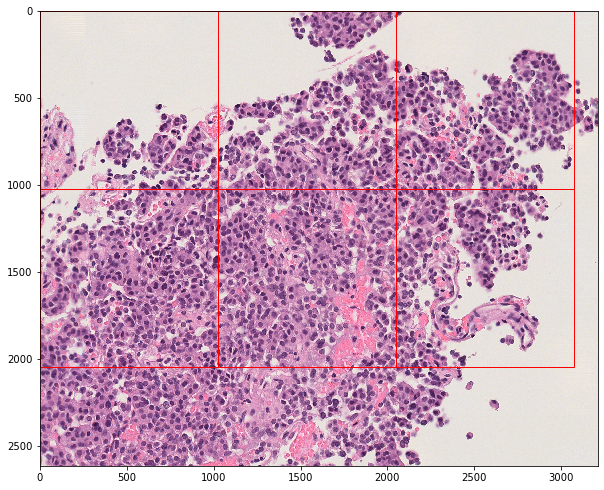

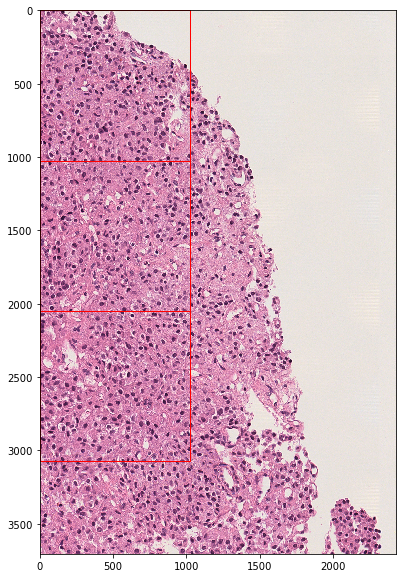

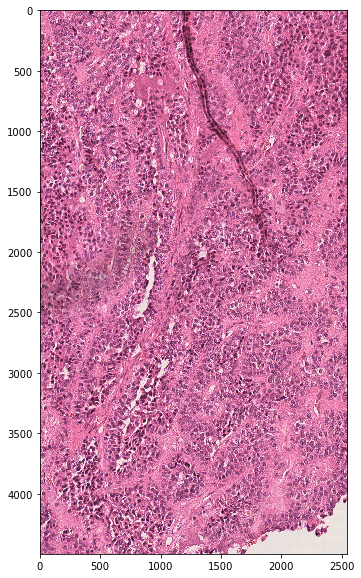

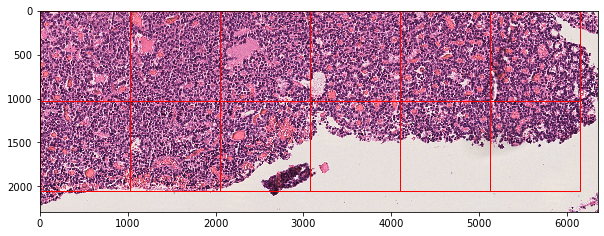

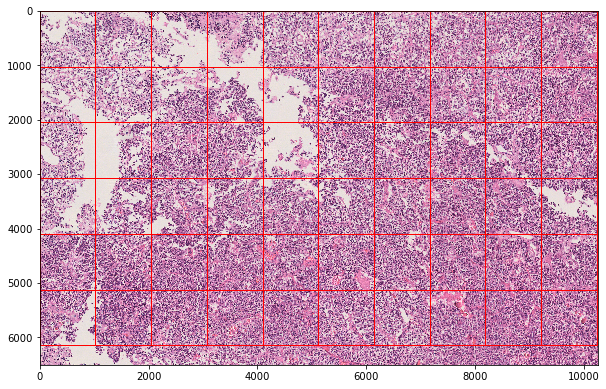

In [99]:
for ts in tilesummaries:
    ts.show_wsi_with_marked_tiles()

## ObjectManager

In [11]:
object_manager=ObjectManager(named_objects, splitter=sklearn.model_selection.train_test_split)

In [100]:
object_manager.convert_to_wsi_or_roi_object_by_tilesummaries(tilesummaries=tilesummaries)

In [101]:
object_manager.export_dataframe()

fname  labels  \
0   [Tile #57, Row #6, Column #2, Tissue 57.26%, Score 0.8394]     [9]   
1   [Tile #45, Row #5, Column #1, Tissue 51.04%, Score 0.8365]     [9]   
2   [Tile #28, Row #3, Column #6, Tissue 45.41%, Score 0.8286]     [9]   
3   [Tile #13, Row #2, Column #2, Tissue 24.27%, Score 0.8184]     [9]   
4    [Tile #2, Row #1, Column #2, Tissue 25.63%, Score 0.8166]     [9]   
..                                                         ...     ...   
76   [Tile #1, Row #1, Column #1, Tissue 70.20%, Score 0.7921]  [8, 9]   
77  [Tile #10, Row #2, Column #3, Tissue 59.73%, Score 0.7901]  [8, 9]   
78  [Tile #13, Row #2, Column #6, Tissue 36.05%, Score 0.7774]  [8, 9]   
79  [Tile #12, Row #2, Column #5, Tissue 32.49%, Score 0.7765]  [8, 9]   
80  [Tile #11, Row #2, Column #4, Tissue 26.62%, Score 0.6690]  [8, 9]   

    is_valid                                          patient_id case_id  \
0      False  <function get_case_id_from_path at 0x7f1831aaa320>  931-13   
1      False  <function get_case_id_from_path at 0x7f1831aaa320>  931-13   
2      False  <function get_case_id_from_path at 0x7f1831aaa320>  931-13   
3      False  <function get_case_id_from_path at 0x7f1831aaa320>  931-13   
4      False  <function get_case_id_from_path at 0x7f1831aaa320>  931-13   
..       ...                                                 ...     ...   
76     False  <function get_case_id_from_path at 0x7f1831aaa320>  105-15   
77     False  <function get_case_id_from_path at 0x7f1831aaa320>  105-15   
78     False  <function get_case_id_from_path at 0x7f1831aaa320>  105-15   
79     False  <function get_case_id_from_path at 0x7f1831aaa320>  105-15   
80     False  <function get_case_id_from_path at 0x7f1831aaa320>  105-15   

       slide_id dataset_type  \
0   931-13-Z-HE         None   
1   931-13-Z-HE         None   
2   931-13-Z-HE         None   
3   931-13-Z-HE         None   
4   931-13-Z-HE         None   
..          ...          ...   
76  105-15-Z-HE         None   
77  105-15-Z-HE         None   
78  105-15-Z-HE         None   
79  105-15-Z-HE         None   
80  105-15-Z-HE         None   

                                                                                                   path  
0      /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_16-FSH.png  
1      /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_16-FSH.png  
2      /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_16-FSH.png  
3      /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_16-FSH.png  
4      /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_16-FSH.png  
..                                                                                                  ...  
76  /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_27-LH+FSH.png  
77  /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_27-LH+FSH.png  
78  /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_27-LH+FSH.png  
79  /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_27-LH+FSH.png  
80  /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_27-LH+FSH.png  

[81 rows x 8 columns]

In [161]:
valid_pct = 0.2

In [102]:
object_manager.split(test_size=valid_pct, train_size=None, random_state=seed, shuffle=True, stratify=None)

In [103]:
object_manager.export_dataframe()

fname  labels  \
0   [Tile #57, Row #6, Column #2, Tissue 57.26%, Score 0.8394]     [9]   
1   [Tile #45, Row #5, Column #1, Tissue 51.04%, Score 0.8365]     [9]   
2   [Tile #28, Row #3, Column #6, Tissue 45.41%, Score 0.8286]     [9]   
3   [Tile #13, Row #2, Column #2, Tissue 24.27%, Score 0.8184]     [9]   
4    [Tile #2, Row #1, Column #2, Tissue 25.63%, Score 0.8166]     [9]   
..                                                         ...     ...   
76   [Tile #1, Row #1, Column #1, Tissue 70.20%, Score 0.7921]  [8, 9]   
77  [Tile #10, Row #2, Column #3, Tissue 59.73%, Score 0.7901]  [8, 9]   
78  [Tile #13, Row #2, Column #6, Tissue 36.05%, Score 0.7774]  [8, 9]   
79  [Tile #12, Row #2, Column #5, Tissue 32.49%, Score 0.7765]  [8, 9]   
80  [Tile #11, Row #2, Column #4, Tissue 26.62%, Score 0.6690]  [8, 9]   

    is_valid patient_id case_id     slide_id       dataset_type  \
0      False       None  931-13  931-13-Z-HE  DatasetType.train   
1      False       None  931-13  931-13-Z-HE  DatasetType.train   
2      False       None  931-13  931-13-Z-HE  DatasetType.train   
3      False       None  931-13  931-13-Z-HE  DatasetType.train   
4      False       None  931-13  931-13-Z-HE  DatasetType.train   
..       ...        ...     ...          ...                ...   
76     False       None  105-15  105-15-Z-HE  DatasetType.train   
77     False       None  105-15  105-15-Z-HE  DatasetType.train   
78     False       None  105-15  105-15-Z-HE  DatasetType.train   
79     False       None  105-15  105-15-Z-HE  DatasetType.train   
80     False       None  105-15  105-15-Z-HE  DatasetType.train   

                                                                                                   path  
0      /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_16-FSH.png  
1      /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_16-FSH.png  
2      /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_16-FSH.png  
3      /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_16-FSH.png  
4      /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_16-FSH.png  
..                                                                                                  ...  
76  /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_27-LH+FSH.png  
77  /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_27-LH+FSH.png  
78  /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_27-LH+FSH.png  
79  /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_27-LH+FSH.png  
80  /home/Deep_Learner/private/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_27-LH+FSH.png  

[81 rows x 8 columns]

## data block api

In [104]:
splits = fastai2.data.transforms.FuncSplitter(lambda x: x.is_valid)
tfm=TileTransform(object_manager.get_all_top_tiles(), splits=splits)
tfm

TileTransform: (object,object) -> encodes 

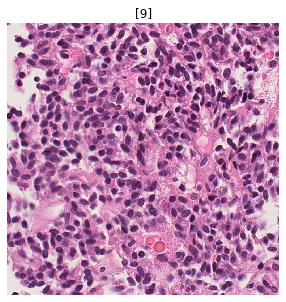

In [105]:
tfm.encodes(object_manager.get_all_top_tiles()[0]).show()

In [106]:
tls = fastai2.data.core.TfmdLists(object_manager.get_all_top_tiles(), tfm);tls

TfmdLists: [
[Tile #57, Row #6, Column #2, Tissue 57.26%, Score 0.8394], 
[Tile #45, Row #5, Column #1, Tissue 51.04%, Score 0.8365], 
[Tile #28, Row #3, Column #6, Tissue 45.41%, Score 0.8286], 
[Tile #13, Row #2, Column #2, Tissue 24.27%, Score 0.8184], 
[Tile #2, Row #1, Column #2, Tissue 25.63%, Score 0.8166], 
[Tile #46, Row #5, Column #2, Tissue 53.90%, Score 0.8152], 
[Tile #31, Row #3, Column #9, Tissue 46.00%, Score 0.8097], 
[Tile #17, Row #2, Column #6, Tissue 44.21%, Score 0.8026], 
[Tile #25, Row #3, Column #3, Tissue 44.21%, Score 0.7991], 
[Tile #32, Row #3, Column #10, Tissue 50.13%, Score 0.7959], 
[Tile #18, Row #2, Column #7, Tissue 52.73%, Score 0.7925], 
[Tile #14, Row #2, Column #3, Tissue 28.18%, Score 0.7909], 
[Tile #47, Row #5, Column #3, Tissue 57.79%, Score 0.7908], 
[Tile #1, Row #1, Column #1, Tissue 20.63%, Score 0.7852], 
[Tile #58, Row #6, Column #3, Tissue 53.66%, Score 0.7845], 
[Tile #29, Row #3, Column #7, Tissue 46.99%, Score 0.7822], 
[Tile #5, Ro

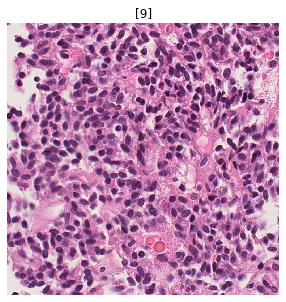

In [107]:
fastai2.data.core.show_at(tls, 0)

In [142]:
data = fastai2.data.block.DataBlock(
        blocks=(TileImageBlock, fastai2.data.block.MultiCategoryBlock),
        get_x=lambda x: x, 
        get_y=lambda x: x.classification_labels,
        splitter=fastai2.data.transforms.FuncSplitter(lambda x: x.is_valid),
        item_tfms=fastai2.vision.augment.Resize(512),
        batch_tfms=[fastai2.data.transforms.Normalize.from_stats(*fastai2.vision.all.imagenet_stats)].append(fastai2.vision.augment.aug_transforms(flip_vert=True)))

In [143]:
dls = data.dataloaders(object_manager.get_all_top_tiles(), bs=bs)

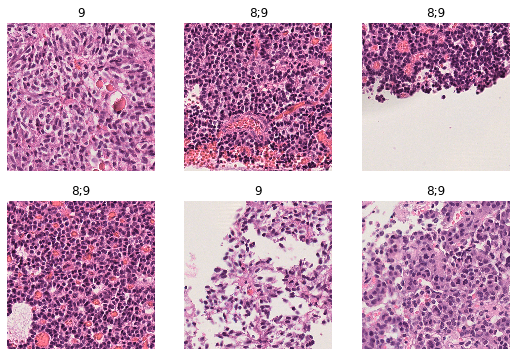

In [144]:
dls.show_batch()

# learner

## n

In [153]:
n = np.load('n_ent_f2.npy')
print(n)
#m = n+1
m=1
np.save('n_ent_f2.npy', m)
print(m)

1
1


## extra models

In [147]:
#https://github.com/PPPW/deep-learning-random-explore/blob/master/CNN_archs/cnn_archs.ipynb

def identity(x): return x

def nasnetamobile(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.nasnetamobile(pretrained=pretrained, num_classes=1000)  
    model.logits = identity
    model_meta[nasnetamobile] =  { 'cut': identity, 'split': lambda m: (list(m[0][0].children())[8], m[1]) }
    return nn.Sequential(model)

#arch_summary(lambda _: nasnetamobile(False)[0])

def se_resnext50_32x4d(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext50_32x4d(pretrained=pretrained)
    model_meta[se_resnext50_32x4d] =  {'cut': -2, 'split': lambda m: (m[0][3], m[1]) }
    return model

#arch_summary(lambda _: pretrainedmodels.se_resnext50_32x4d(pretrained=None))

def se_resnext101_32x4d(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext101_32x4d(pretrained=pretrained)
    model_meta[se_resnext101_32x4d] =  {'cut': -2, 'split': lambda m: (m[0][3], m[1]) }
    return model

def xception(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.xception(pretrained=pretrained)
    model_meta[xception] =  { 'cut': -1, 'split': lambda m: (m[0][11], m[1]) }
    return model

def inceptionv4(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.inceptionv4(pretrained=pretrained)
    model_meta[xception] =  { 'cut': -2, 'split': lambda m: (m[0][11], m[1]) }
    return model

## create

In [167]:
epochs_frozen = 5
epochs_unfrozen = 10

In [168]:
arch = resnext101_32x8d
learner = cnn_learner(dls=dls, 
                     arch=arch, 
                     metrics=[fastai2.metrics.accuracy_multi, fastai2.metrics.RocAucMulti],
                     pretrained=True)

## name

In [169]:
#nameBase = f'{n}-{arch.__name__}-size{sz}-bs{bs}-epochs_head{epochs_frozen}-epochs_complete{epochs_unfrozen}-seed_{seed}-valid_pct_{valid_pct}-n_splits_{n_splits}-tiles_1+2+3-cross_valid_iteration_{iteration}'
nameBase = f'{n}-{arch.__name__}-size{sz}-bs{bs}-epochs_head{epochs_frozen}-epochs_complete{epochs_unfrozen}-seed_{seed}-valid_pct_{valid_pct}'
nameBase

'1-resnext101_32x8d-size512-bs6-epochs_head5-epochs_complete10-seed_19-valid_pct_0.2'

## train

In [170]:
lr_min, lr_steep=learner.lr_find(start_lr=1e-10, end_lr=10, num_it=1000)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.92 GiB total capacity; 7.40 GiB already allocated; 20.00 MiB free; 7.41 GiB reserved in total by PyTorch)